In [1]:
import matplotlib.pyplot as plt
from IPython import get_ipython


In [2]:
import seaborn as sns
import numpy as np
import multiprocessing as mp
from IPython import get_ipython


  # AGNN RS model implementation
  This file implements the Artificial Genetic Neural Network recommender system, using the [AGGN journal](journals/AGNN.pdf).

  ## 2. Collect dataset

  The rating matrix has been generated using the [ratings_matrix.ipynb](./ratings_matrix.ipynb) script.

In [3]:

# Reading the ratings matrix

import pandas as pd

ratings_matrix = pd.read_csv('data/ratings_matrix.csv')
# Limiting number of cols. as it would take a week to run.
ratings_matrix = ratings_matrix.iloc[:, :100]
ratings_matrix


,userId,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,110,111
0,1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,3.5,3.5
606,607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
607,608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,3.0,NaN,4.0,3.0
608,609,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN


  ## 3. Calculate `sim(om_s, om_t)` using (1);

  ![Similarity function](images/eq_1.png)

In [4]:

# 3: Calculate sim(om_s, om_t) using (1);


def sim(om_s: pd.DataFrame, om_t: pd.DataFrame) -> float:
    """Generates a similarity value between two online movies."""

    # Merging the two movies so we can find common users who rated both
    temp_om = pd.concat([om_s, om_t], axis=1)

    # Dropping rows with NaNs as this yields movies with common ratings
    common_om = temp_om.dropna()

    # Checking if there are common users
    if common_om.empty:
        # If there are no users, return
        return None

    # Splitting the data again
    om_s = common_om.iloc[:, 0]
    om_t = common_om.iloc[:, 1]

    # Getting similarity
    similarity = sum(om_s * om_t) / sum(om_s + om_t)
    return similarity



In [5]:

# Function to calculate the average similarity for each movie in the matrix.

def avg_sim(batch_matrix: pd.DataFrame):
    """Calculates the average movie similarity."""
    similarities_list = []  # Where the average similarities will be stored.

    # Iterating over every movie
    for om_s_id, om_s in batch_matrix.iteritems():

        if om_s.empty:
            continue

        similarities = []
        # Iterating over movies to check similarity against
        for om_t_id, om_t in ratings_matrix.iteritems():

            # Making sure we don't check the similarity of a movie against itself
            if om_s_id == om_t_id:
                continue

            similarity = sim(om_s, om_t)

            # Ignore the movie if there are no common users
            if similarity is None:
                continue

            similarities.append(similarity)

        # Calculating average similarity
        avg_similarity = sum(similarities) / len(ratings_matrix.columns)

        # Appending ID and avg. sim. to list
        similarities_list.append((om_s_id, avg_similarity))
        print(f"Done movieId {om_s_id}")

    return similarities_list


# Making sure we have access to the original ratings matrix
original_ratings_matrix = ratings_matrix.copy()



In [6]:
# Dropping the `userId` column, as it is not necessary for this step.

ratings_matrix.drop('userId', axis=1, inplace=True)
ratings_matrix.head()



,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,110,111
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


In [7]:

# Processing similarities in parallel

if __name__ == "__main__":
    cpu_count = mp.cpu_count()

    batch_matrices = np.array_split(ratings_matrix, cpu_count, axis=1)

    pool = mp.Pool(cpu_count)
    similarities_list = pool.map(avg_sim, batch_matrices)
    similarities_list

print('Completed processing similarities.')



Done movieId 83
Done movieId 103
Done movieId 75Done movieId 66

Done movieId 94
Done movieId 57Done movieId 28Done movieId 19
Done movieId 10


Done movieId 1
Done movieId 39
Done movieId 47
Done movieId 85
Done movieId 68
Done movieId 40
Done movieId 58
Done movieId 104Done movieId 11Done movieId 29

Done movieId 2
Done movieId 95Done movieId 20Done movieId 76



Done movieId 48
Done movieId 86
Done movieId 69
Done movieId 41
Done movieId 30
Done movieId 60
Done movieId 3Done movieId 96
Done movieId 12

Done movieId 105
Done movieId 21
Done movieId 77
Done movieId 49
Done movieId 42
Done movieId 87
Done movieId 70
Done movieId 31Done movieId 97Done movieId 61


Done movieId 4
Done movieId 13Done movieId 106

Done movieId 78
Done movieId 50
Done movieId 22
Done movieId 43
Done movieId 71
Done movieId 99
Done movieId 88
Done movieId 62
Done movieId 32
Done movieId 79
Done movieId 5
Done movieId 14
Done movieId 52
Done movieId 23
Done movieId 107Done movieId 72Done movieId 44


Done mov

In [8]:

# Flattening the list (it is currently a list of lists.)
similarities_list = [item for sublist in similarities_list for item in sublist]
print(similarities_list)



[('1', 1.7285014501875697), ('2', 1.4257422061886476), ('3', 1.4467299326156116), ('4', 0.9376800180261771), ('5', 1.3675116024007359), ('6', 1.6656314630546112), ('7', 1.442884964053463), ('8', 1.2052954667054572), ('9', 1.0988220628744068), ('10', 1.3901589342610532), ('11', 1.508293845214025), ('12', 1.0210390648245082), ('13', 0.9777705716454976), ('14', 1.4006479010430075), ('15', 1.172902217990355), ('16', 1.6321810889851918), ('17', 1.6321118940765649), ('18', 1.3207357917671434), ('19', 1.219716427943174), ('20', 0.8339768737269185), ('21', 1.546428883206619), ('22', 1.3586428800752592), ('23', 1.1115151592852694), ('24', 1.344088294512085), ('25', 1.5956497572256738), ('26', 1.3476285307414357), ('27', 1.227176900162714), ('28', 1.2350301741029337), ('29', 1.530193943817273), ('30', 0.6008257174923841), ('31', 1.3130380443440657), ('32', 1.6942698517678196), ('34', 1.6246933650802944), ('36', 1.7010898001761123), ('38', 0.5533897419843827), ('39', 1.4310309657270026), ('40', 0

In [9]:

# Sorting the list

similarities_list = sorted(
    similarities_list, key=lambda tupl: tupl[1], reverse=True)
print(similarities_list)



[('1', 1.7285014501875697), ('36', 1.7010898001761123), ('32', 1.6942698517678196), ('6', 1.6656314630546112), ('16', 1.6321810889851918), ('110', 1.632115781792621), ('17', 1.6321118940765649), ('34', 1.6246933650802944), ('62', 1.6051019063333158), ('25', 1.5956497572256738), ('111', 1.5782057919709604), ('50', 1.5743923920896936), ('47', 1.5686303453870756), ('21', 1.546428883206619), ('29', 1.530193943817273), ('11', 1.508293845214025), ('45', 1.4839790538509705), ('104', 1.451287938159261), ('52', 1.4501012297077798), ('3', 1.4467299326156116), ('7', 1.442884964053463), ('70', 1.4362274593184985), ('39', 1.4310309657270026), ('2', 1.4257422061886476), ('101', 1.4154573761058646), ('14', 1.4006479010430075), ('58', 1.3981358605022935), ('95', 1.3937285079812691), ('10', 1.3901589342610532), ('86', 1.3709077436764519), ('5', 1.3675116024007359), ('76', 1.3666929528225273), ('22', 1.3586428800752592), ('26', 1.3476285307414357), ('24', 1.344088294512085), ('41', 1.3403770071784467), 

In [10]:

# Dropping movies with om_s <= Outlier (0.3 in the paper.)
# First step: get movie IDs below or at outlier to drop.

outlier = 0.3
list_to_drop = [item for item in similarities_list if item[1] <= outlier]
print(list_to_drop)



[('49', 0.21937229437229436), ('40', 0.16343995510662176), ('106', 0.0962000962000962), ('83', 0.08787878787878788)]


In [11]:

# Order ratings matrix based on similarity

new_order = [item[0] for item in similarities_list]
print(new_order)



['1', '36', '32', '6', '16', '110', '17', '34', '62', '25', '111', '50', '47', '21', '29', '11', '45', '104', '52', '3', '7', '70', '39', '2', '101', '14', '58', '95', '10', '86', '5', '76', '22', '26', '24', '41', '18', '46', '94', '31', '43', '107', '60', '57', '89', '79', '92', '105', '100', '48', '28', '27', '19', '61', '8', '15', '97', '81', '88', '65', '73', '23', '93', '74', '9', '44', '66', '69', '12', '72', '13', '82', '4', '54', '87', '42', '78', '85', '20', '75', '63', '102', '103', '96', '99', '68', '71', '64', '30', '53', '38', '77', '108', '80', '55', '49', '40', '106', '83']


In [12]:

# Ordering the matrix

# Making sure User ID is always the first column
new_order.insert(0, 'userId')

ordered_matrix = original_ratings_matrix.reindex(new_order, axis=1)
ordered_matrix



,userId,1,36,32,6,16,110,17,34,62,...,53,38,77,108,80,55,49,40,106,83
0,1,4.0,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,5,4.0,4.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,2.5,3.5,4.0,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
606,607,4.0,4.0,NaN,NaN,NaN,5.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,608,2.5,NaN,3.5,NaN,4.5,4.0,NaN,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,609,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:

# Dropping columns with similarity lower than threshold

cols_to_drop = [item[0] for item in list_to_drop]

filtered_matrix = ordered_matrix.drop(cols_to_drop, axis=1)

filtered_matrix



,userId,1,36,32,6,16,110,17,34,62,...,68,71,64,30,53,38,77,108,80,55
0,1,4.0,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4.0,4.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,2.5,3.5,4.0,NaN,NaN,3.5,4.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
606,607,4.0,4.0,NaN,NaN,NaN,5.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,608,2.5,NaN,3.5,NaN,4.5,4.0,NaN,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,609,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


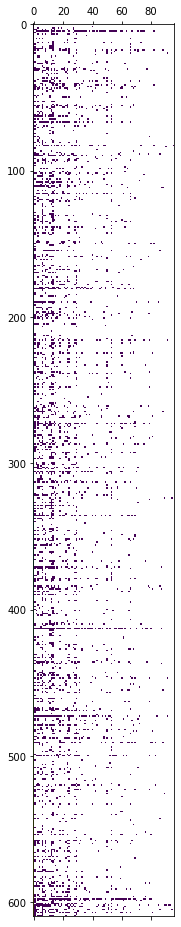

In [14]:

# Plotting the results


get_ipython().run_line_magic('matplotlib', 'inline')

plt.matshow(filtered_matrix)



In [15]:

# Creating table from matrix (?)

filtered_table = filtered_matrix.melt(
    id_vars=['userId'], var_name="movieId", value_name="rating").dropna()

filtered_table['userId'] = filtered_table['userId'].astype(int)
filtered_table['movieId'] = filtered_table['movieId'].astype(int)

filtered_table



,userId,movieId,rating
0,1,1,4.0
4,5,1,4.0
6,7,1,4.5
14,15,1,2.5
16,17,1,4.5
...,...,...,...
56112,603,77,4.0
56722,603,108,4.0
57054,325,80,4.0
57335,606,80,4.0


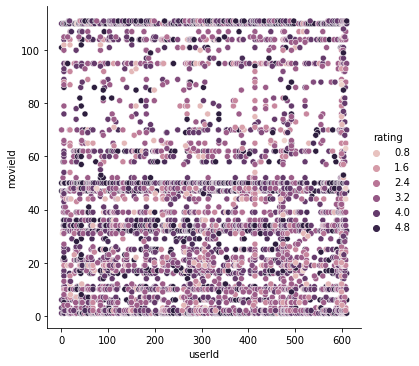

In [16]:

# Plotting the table

sns.relplot(data=filtered_table, x='userId', y='movieId', hue='rating')



In [18]:

# Creating modified k-means clustering algorithm

# def euclidian_dist(t, c):


# # N is the number of clusters to create.
# def cluster_data(data: pd.DataFrame, n: int):
#     # Selecting random k data points as cluster centroids
#     centroids = data.sample(n=n)

#     max_iteration = 300
#     while max_iteration != 0:

np_table = filtered_table.to_numpy
np_table


<bound method DataFrame.to_numpy of        userId  movieId  rating
0           1        1     4.0
4           5        1     4.0
6           7        1     4.5
14         15        1     2.5
16         17        1     4.5
...       ...      ...     ...
56112     603       77     4.0
56722     603      108     4.0
57054     325       80     4.0
57335     606       80     4.0
57423      84       55     4.0

[3723 rows x 3 columns]>